<table style="background-color: rgb(13,32,76); border-radius: 10px">
	<thead>
		<tr>
			<th colspan="2" style="border: hidden; vertical-align: top;" width="15%"><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1674755226__Icons_400px_Practice Assignment.png">
			</th>
			<th style="border: hidden;">
				<h1 style="color: white;">Data Augmentation (Practice)</h1>
			</th>
		</tr>
	</thead>
</table>
<p>This practice assignment will reinforce important learning objectives from the previous lesson(s), and allow you to take on more challenging core assignments, preparing you for graduation.<br></p>
<p>Practice and tinker with this assignment until you're comfortable performing each of the tasks. Then, be sure to submit your output as described in the steps below.</p>
<hr>
<h2><span style="background-color: initial; font-family: Gotham-Rounded-Bold; font-size: 24px;">Data Augmentation (Practice)</span></h2>
<ul><li>For this assignment, you will continue working with the Dangerous Farm Insects data set from Kaggle: <a href="https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset" target="_blank" class="url">https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset</a></li>
<li><strong>Your goal is to add data augmentation to your model and compare it against your best model from the Tuning CNNs practice assignment.</strong></li>
</ul>
<p><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1692317485__Screenshot20230817at81117PM.png" referrerpolicy="no-referrer" alt="img"></p>
<h2>Getting Started</h2>
<ul>
<li>Continue working in your repository from the previous practice assignment.</li>
<li>Duplicate/make a copy of your previous notebook.</li>
<li>Select your best model from the previous assignment to add data augmentation to.</li>
<li>Comment out (or delete)  the code for the models that you did not select as your best. </li>
<li>Re-run your previous code to fit and evaluate your baseline/best model.</li>
</ul>
<p> </p>
<h3>Create a Data Augmentation Object</h3>
<ul>
<li>Create a Data Augmentation model/pipeline.
<ul>
<li>Use at least 3 keras preprocessing/transformation layers. (e.g. RandomCrop, RandomZoom, etc)</li>
</ul>
<p> </p>
</li>
</ul>
<h4>Visualize the Effect of the Data Augmentation <em>(Optional, but Recommended):</em> </h4>
<ul>
<li>Extract an example batch of images and select a single example image. 
<ul>
<li>Use a loop to apply your data augmentation to the image several times. </li>
<li>Display the transformed image with either Keras (array_to_img) or Matplotlib (plt.imshow/ ax.imshow)</li>
</ul>
</li>
</ul>
<p> </p>
<h3>Add the Data Augmentation Object to Your Model</h3>
<ul>
<li>Add the data augmentation object as the second layer in your CNN model, after your rescaling layer. 
</li>
<li>FIt and evaluate the augmented model and compare against your previous best. 
</li>
<li>In a Markdown cell, answer the question:
<ul>
<li>Did the model get better or worse?</li>
<li>If it gets better, then this is your new best model!</li>
<li>If it gets worse, consider trying a more conservative option (smaller rotations/zooms, etc.) or adding additional complexity to your model (e.g., more layers)</li>
</ul>
</li>
</ul>
<h2>Solution</h2>

In [1]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

In [2]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
# from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
tf.__version__

'2.12.0'

In [3]:
# Define custom function
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [4]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [5]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [6]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict





In [7]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    
    return results_dict

In [8]:
# Checking the contents of xrays folder
data_dir = "Data/Dangerous Insects/farm_insects/"
data_dir

'Data/Dangerous Insects/farm_insects/'

In [9]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

1591

In [10]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(650, 1160, 3)

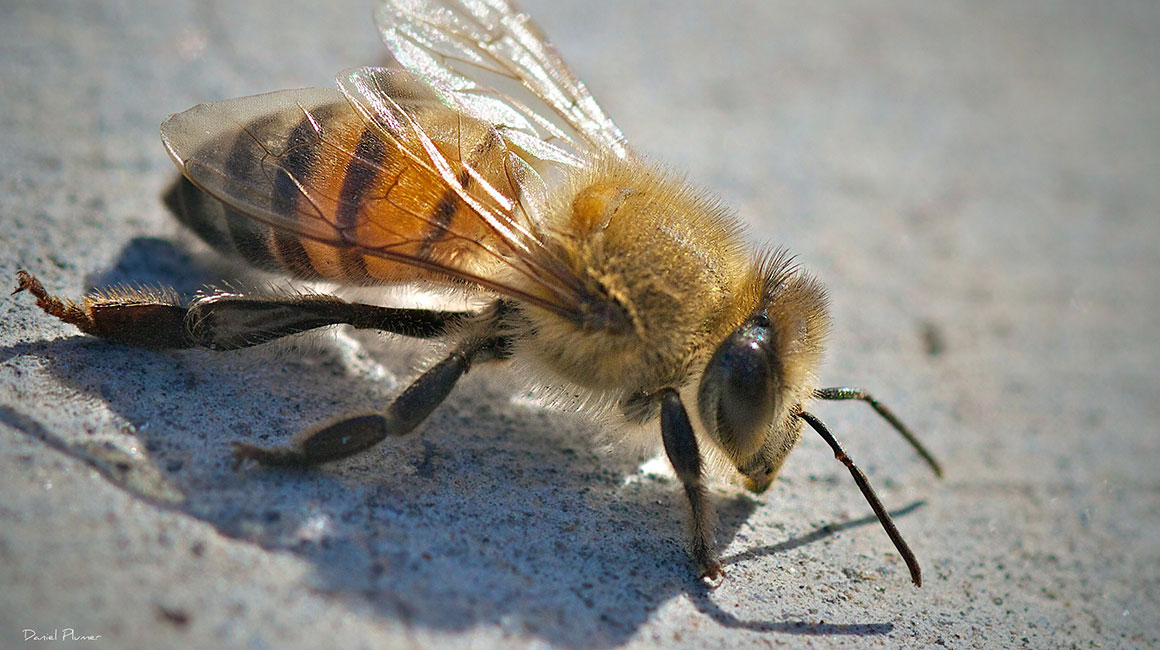

In [11]:
# Data can be converted back to image
array_to_img(img_data)

In [12]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 96
img_width = 96

In [13]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds

Found 1591 files belonging to 15 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [14]:
class_names = ds.class_names
class_names

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

In [15]:
#Set the size of the train, test, and validation
split_train = 0.7
split_val = 0.2
split_test = .1 

# Calculate the number of batches for training and validation data 
n_train_batches =  int(len(ds) * split_train)
n_val_batches = int(len(ds) * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 35 batches as training data
Use 10 batches as validation data
The remaining 5 batches will be used as test data.


In [16]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)

## Create the val_ds from original ds
# 1. Skipping over the training batches
val_ds = ds.skip(n_train_batches)
# 2. Taking the correct number of validation batches
val_ds = val_ds.take(n_val_batches)

# Create the test split from ds
# SKip over all of the training + val images
test_ds = ds.skip(n_train_batches + n_val_batches)

len(train_ds), len(val_ds), len(test_ds)

(35, 10, 5)

In [17]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# ORIGINAL SHUFFLED TRAIN
train_ds = train_ds.cache().shuffle(buffer_size= train_ds.cardinality(),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
# taking a sample banch to see batch shape
example_batch_imgs,example_batch_y= train_ds.take(1).get_single_element()
# individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([96, 96, 3])

Note: You should use the model that has given you the best results so far. This model is used as a demonstration, and may not be the best-performing model.

In [19]:
def build_model_dual_conv():
    
    model = models.Sequential()
    # Using rescaling layer to scale pixel values
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))  
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding= 'same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [20]:
# Build model with given arguments
model1= build_model_dual_conv()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

In [21]:
def get_callbacks(patience=3,monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                  monitor=monitor)
    return [early_stop]

In [22]:
# Fit the model
epochs = 25
history = model1.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs, callbacks = get_callbacks(patience = 10))

Epoch 1/25
35/35 [==============================] - 34s 958ms/step - loss: 2.8693 - accuracy: 0.1018 - val_loss: 2.5260 - val_accuracy: 0.2062
Epoch 2/25
35/35 [==============================] - 28s 802ms/step - loss: 2.2904 - accuracy: 0.2884 - val_loss: 2.3698 - val_accuracy: 0.2562
Epoch 3/25
35/35 [==============================] - 27s 778ms/step - loss: 1.8207 - accuracy: 0.4696 - val_loss: 2.1760 - val_accuracy: 0.3688
Epoch 4/25
35/35 [==============================] - 29s 818ms/step - loss: 1.2007 - accuracy: 0.6634 - val_loss: 2.1633 - val_accuracy: 0.4500
Epoch 5/25
35/35 [==============================] - 28s 800ms/step - loss: 0.5908 - accuracy: 0.8518 - val_loss: 2.0167 - val_accuracy: 0.5031
Epoch 6/25
35/35 [==============================] - 27s 766ms/step - loss: 0.2805 - accuracy: 0.9429 - val_loss: 2.0717 - val_accuracy: 0.5094
Epoch 7/25
35/35 [==============================] - 27s 763ms/step - loss: 0.1918 - accuracy: 0.9723 - val_loss: 2.3232 - val_accuracy: 0.5125

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

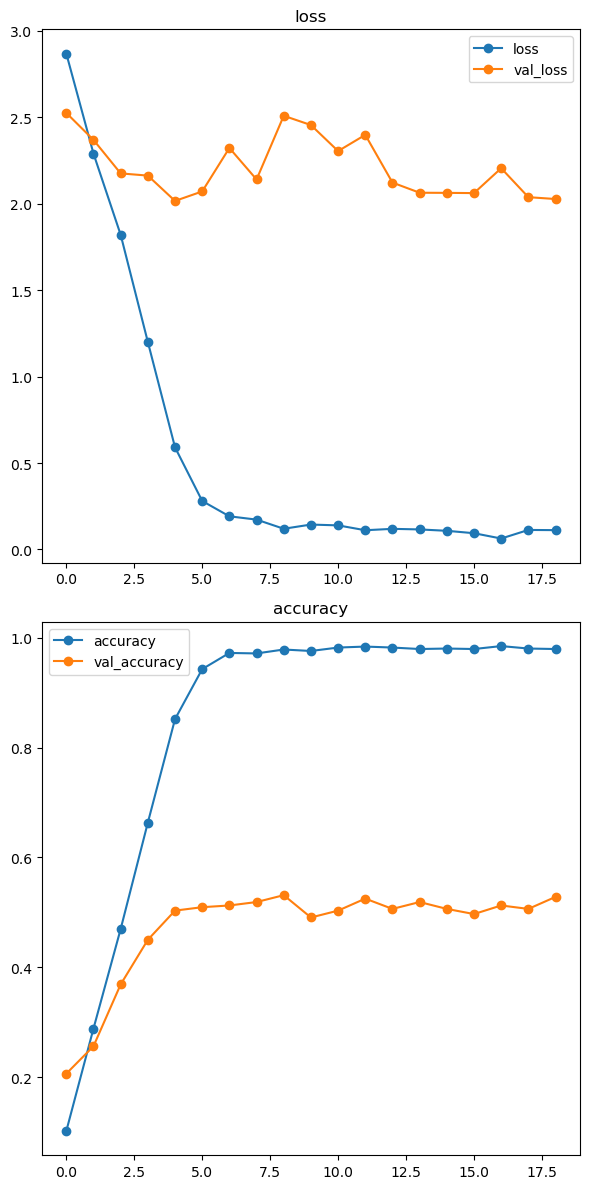

In [23]:
plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        62
           2       0.86      0.94      0.90        72
           3       1.00      1.00      1.00        83
           4       1.00      1.00      1.00        69
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        76
           7       1.00      1.00      1.00        82
           8       1.00      1.00      1.00        76
           9       0.95      0.87      0.90        82
          10       1.00      1.00      1.00        71
          11       1.00      1.00      1.00        82
          12       1.00      1.00      1.00        78
          13       1.00      1.00    

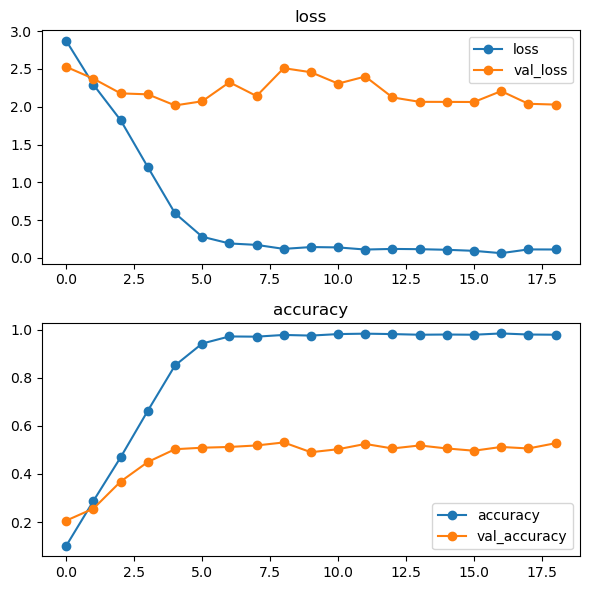

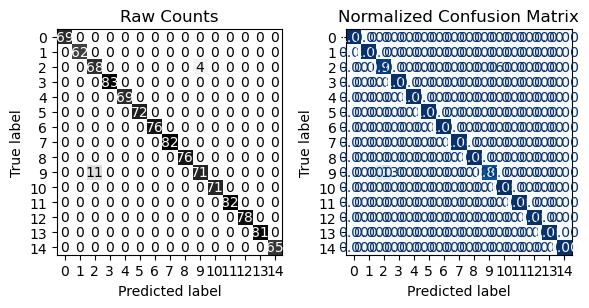


- Evaluating Training Data:
35/35 [==============================] - 7s 205ms/step - loss: 0.0705 - accuracy: 0.9866
{'loss': 0.07049836963415146, 'accuracy': 0.9866071343421936}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.20      0.14      0.17         7
           2       0.28      0.50      0.36        10
           3       0.29      0.57      0.38         7
           4       0.55      0.60      0.57        10
           5       0.50      0.67      0.57         9
           6       0.67      0.22      0.33         9
           7       0.75      0.60      0.67        10
           8       0.91      0.71      0.80        14
           9       0.20      0.11      0.14         9
          10       0.42      0.38      0.40     

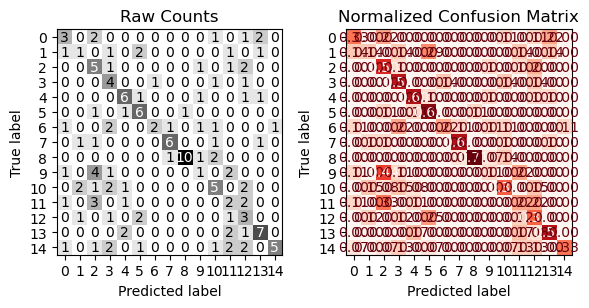


- Evaluating Test Data:
5/5 [==============================] - 1s 166ms/step - loss: 2.4975 - accuracy: 0.4371
{'loss': 2.4974610805511475, 'accuracy': 0.4370861053466797}


In [24]:
# Call custom function to evaluate
evaluate_classification_network(model1, X_train = train_ds, X_test = test_ds, figsize = (6,8), history = history);

# Data Augmentation

In [25]:
# Define data augmentation layer
data_augmentation = models.Sequential(
    [
        # Randomly flip image orientation
        layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
        # Randomly rotate the image (+ values means rotating counter clock-wise)
        layers.RandomRotation(0.15),
        layers.RandomZoom(
            height_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (height)
            width_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (width)
        ),
    ]
)
data_augmentation

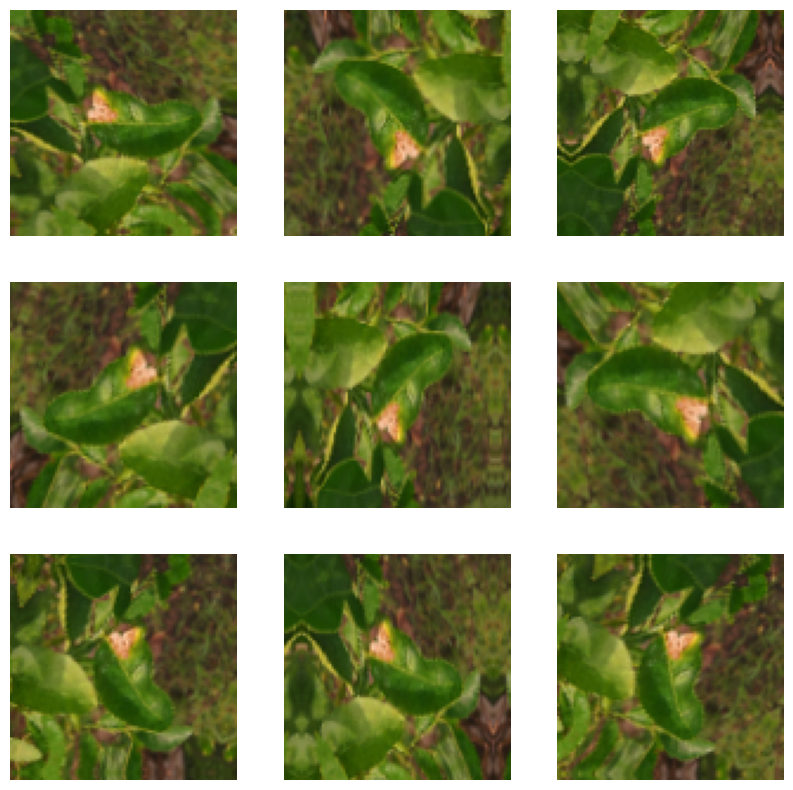

In [26]:
# Explore effects of data augmentation
fig, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)
axes = axes.flatten()

for images, _ in train_ds.take(1):
  for i,ax in enumerate(axes):#range(9):
    augmented_images = data_augmentation(images)
    ax.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
    ax.axis("off")

In [27]:
def build_model_dual_conv_augmented():

    model = models.Sequential()
    # Using rescaling layer to scale pixel values
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    # Add data Augmentation here
    model.add(data_augmentation)
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding= 'same'
        ))  
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters= 64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters= 64,  # How many filters you want to use
            kernel_size= 3,  # size of each filter
            input_shape=input_shape,
            padding= 'same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [28]:
model1_aug= build_model_dual_conv_augmented()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        36928     
                                                      

In [29]:
# Fit the model
epochs = 25
history = model1_aug.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs, callbacks = get_callbacks(patience = 10))

Epoch 1/25
35/35 [==============================] - 29s 802ms/step - loss: 2.9991 - accuracy: 0.1134 - val_loss: 2.7648 - val_accuracy: 0.1250
Epoch 2/25
35/35 [==============================] - 28s 803ms/step - loss: 2.5606 - accuracy: 0.1589 - val_loss: 2.5745 - val_accuracy: 0.1562
Epoch 3/25
35/35 [==============================] - 28s 796ms/step - loss: 2.5098 - accuracy: 0.1813 - val_loss: 2.5908 - val_accuracy: 0.1719
Epoch 4/25
35/35 [==============================] - 29s 827ms/step - loss: 2.4396 - accuracy: 0.2054 - val_loss: 2.5716 - val_accuracy: 0.2031
Epoch 5/25
35/35 [==============================] - 30s 847ms/step - loss: 2.4037 - accuracy: 0.2188 - val_loss: 2.5347 - val_accuracy: 0.2062
Epoch 6/25
35/35 [==============================] - 29s 821ms/step - loss: 2.4007 - accuracy: 0.2179 - val_loss: 2.5523 - val_accuracy: 0.1813
Epoch 7/25
35/35 [==============================] - 28s 795ms/step - loss: 2.3920 - accuracy: 0.2304 - val_loss: 2.5128 - val_accuracy: 0.2313

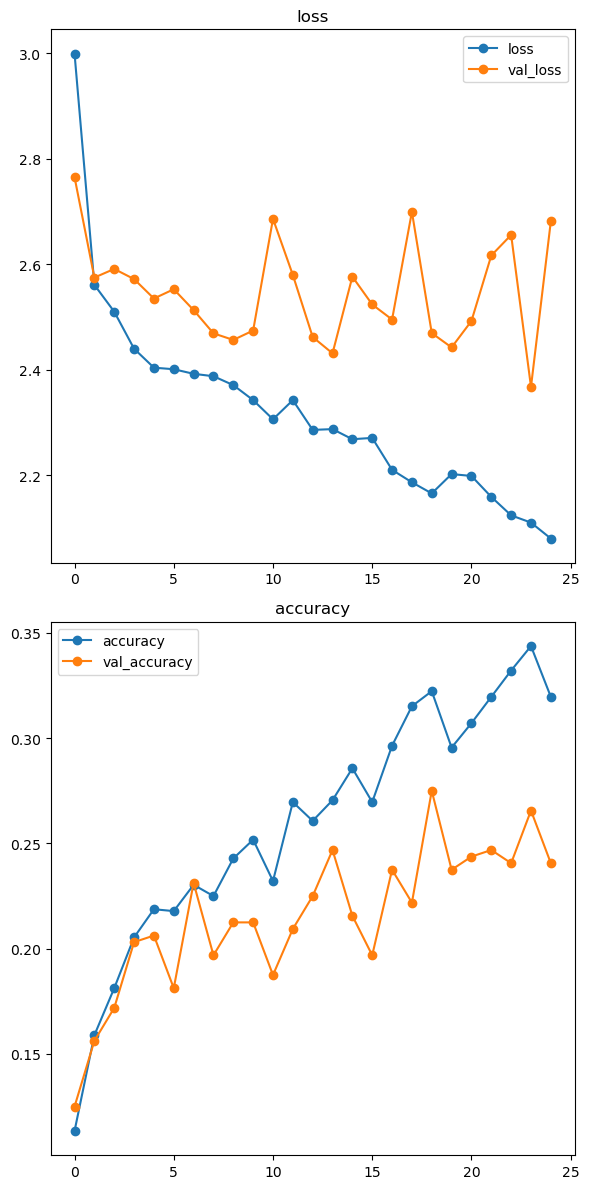

In [30]:
plot_history(history);


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.41      0.22      0.28        69
           1       0.40      0.37      0.38        62
           2       0.23      0.32      0.27        72
           3       0.22      0.93      0.35        83
           4       0.62      0.19      0.29        69
           5       0.64      0.19      0.30        72
           6       0.34      0.55      0.42        76
           7       0.43      0.11      0.17        82
           8       0.38      0.18      0.25        76
           9       0.45      0.12      0.19        82
          10       0.48      0.18      0.27        71
          11       0.20      0.28      0.24        82
          12       0.75      0.08      0.14        78
          13       0.43      0.72    

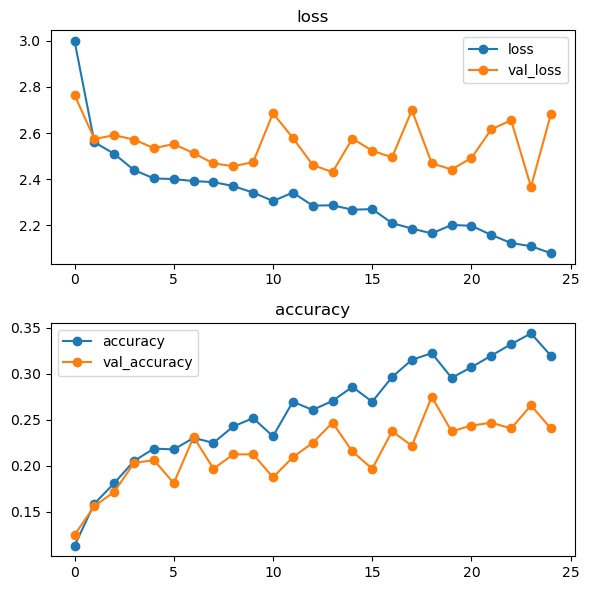

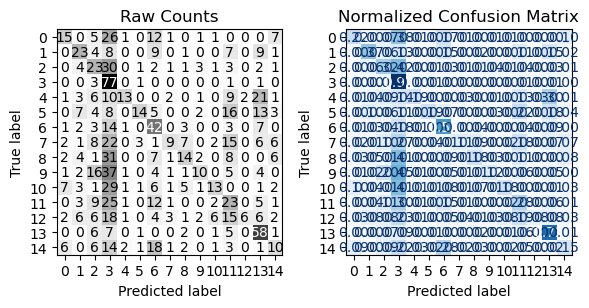


- Evaluating Training Data:
35/35 [==============================] - 8s 225ms/step - loss: 2.3384 - accuracy: 0.3125
{'loss': 2.3384029865264893, 'accuracy': 0.3125}


C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.25      0.11      0.15         9
           1       0.07      0.14      0.09         7
           2       0.25      0.40      0.31        10
           3       0.13      0.86      0.23         7
           4       0.50      0.20      0.29        10
           5       0.00      0.00      0.00         9
           6       0.33      0.56      0.42         9
           7       0.25      0.10      0.14        10
           8       0.25      0.07      0.11        14
           9       0.00      0.00      0.00         9
          10       0.83      0.38      0.53        13
          11       0.08      0.11      0.10         9
          12       0.00      0.00      0.00         8
          13       0.31      0.42      0.36        12
          14

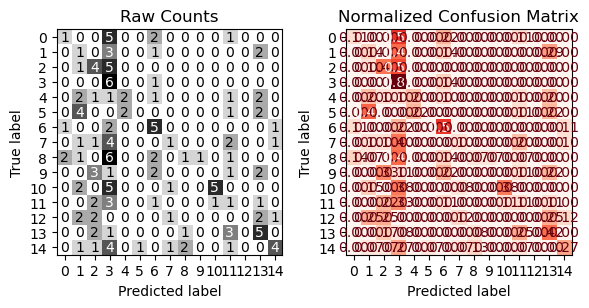


- Evaluating Test Data:
1/5 [=====>........................] - ETA: 0s - loss: 2.6293 - accuracy: 0.2812

C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 1s 179ms/step - loss: 2.6376 - accuracy: 0.2384
{'loss': 2.63761305809021, 'accuracy': 0.2384105920791626}


In [31]:
# Call custom function to evaluate
evaluate_classification_network(model1_aug, X_train = train_ds, X_test = test_ds, figsize = (6,8), history = history);